# Deteksi Tumbuh Kembang Balita
Notebook ini mencakup preprocessing data, training model SVM, evaluasi, penyimpanan model, dan prediksi data baru.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.base import BaseEstimator, TransformerMixin

## Preprocessing Data

In [2]:
# Custom transformer untuk memilih kolom
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.selected_features]

# Load dataset
df = pd.read_csv("data_balita 0-5 gaharu.csv")

In [3]:
df.drop(['No', 'Nama'], axis=1, inplace=True)

In [4]:
df.head()

,Gender,Usia (bulan),TB (cm),BB (kg),BB/U,Z-Score BB/U,BB/TB,Z-Score BB/TB,TB/U,Z-Score TB/U,Perkembangan Anak,Pola Makan,Lingkungan,Imunisasi Dasar,pendapatan keluarga,Hasil
0,Laki-laki,0,47.0,3.0,Normal,-0.89,Gizi Baik,0.85,Normal,-1.98,Sehat,Baik,Aman,Tidak Lengkap,Menengah,Tidak Berisiko
1,Perempuan,1,55.0,4.5,Normal,-0.43,Gizi Baik,-0.12,Normal,-0.37,Normal,Baik,Aman,Tidak Lengkap,Menengah,Tidak Berisiko
2,Laki-laki,2,60.0,5.8,Normal,0.20,Gizi Baik,-0.39,Normal,0.62,Sehat,Baik,Aman,Tidak Lengkap,Menengah,Tidak Berisiko
3,Laki-laki,2,59.0,4.8,Kurang,-2.29,Gizi Kurang,-2.13,Normal,-1.09,Normal,Kurang,Aman,Tidak Lengkap,Menengah,Hampir Berisiko
4,Laki-laki,2,61.0,6.4,Normal,0.10,Gizi Baik,0.26,Normal,-0.11,Sehat,Baik,Aman,Tidak Lengkap,Menengah,Tidak Berisiko


In [5]:
# Mapping nilai kategorikal
df['Gender'] = df['Gender'].map({'Laki-laki': 0, 'Perempuan': 1})
df['BB/U'] = df['BB/U'].map({'Sangat Kurang': 0, 'Kurang': 1, 'Normal': 2, 'Berat Badan Lebih': 3})
df['BB/TB'] = df['BB/TB'].map({'Gizi Buruk': 0, 'Gizi Kurang': 1, 'Gizi Baik': 2, 'Gizi Lebih': 3, 'Obesitas': 4})
df['TB/U'] = df['TB/U'].map({'Sangat Pendek': 0, 'Pendek': 1, 'Normal': 2, 'Tinggi': 3})
df['Perkembangan Anak'] = df['Perkembangan Anak'].map({'Menyimpang': 0, 'Normal': 1, 'Sehat': 2})
df['Pola Makan'] = df['Pola Makan'].map({'Baik': 0, 'Kurang': 1})
df['Lingkungan'] = df['Lingkungan'].map({'Aman': 0, 'Tidak Aman': 1})
df['Imunisasi Dasar'] = df['Imunisasi Dasar'].map({'Lengkap': 0, 'Tidak Lengkap': 1})
df['pendapatan keluarga'] = df['pendapatan keluarga'].map({'Rendah': 0, 'Menengah': 1, 'Tinggi': 2})
df['Hasil'] = df['Hasil'].map({'Tidak Berisiko': 0, 'Hampir Berisiko': 1, 'Berisiko': 2})
df

,Gender,Usia (bulan),TB (cm),BB (kg),BB/U,Z-Score BB/U,BB/TB,Z-Score BB/TB,TB/U,Z-Score TB/U,Perkembangan Anak,Pola Makan,Lingkungan,Imunisasi Dasar,pendapatan keluarga,Hasil
0,0,0,47.0,3.0,2,-0.89,2,0.85,2,-1.98,2,0,0,1,1,0
1,1,1,55.0,4.5,2,-0.43,2,-0.12,2,-0.37,1,0,0,1,1,0
2,0,2,60.0,5.8,2,0.20,2,-0.39,2,0.62,2,0,0,1,1,0
3,0,2,59.0,4.8,1,-2.29,1,-2.13,2,-1.09,1,1,0,1,1,1
4,0,2,61.0,6.4,2,0.10,2,0.26,2,-0.11,2,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1,60,107.7,16.0,2,-0.90,2,-1.08,2,-0.41,2,0,0,0,1,0
206,1,60,108.0,15.0,2,-1.34,2,-1.92,2,-0.28,2,0,0,0,2,0
207,1,60,108.6,16.9,2,-0.51,2,-0.77,2,-0.19,2,0,0,0,1,0
208,1,60,107.0,17.0,2,-0.48,2,-0.30,2,-0.52,2,0,0,0,2,0


In [6]:
X = df.drop('Hasil', axis=1)
y = df['Hasil']

## Seleksi Fitur

In [7]:
# Seleksi fitur menggunakan backward elimination
sfs = SFS(SVC(kernel='linear'),
          k_features='best',  # Pilih jumlah fitur terbaik
          forward=False,      # Backward elimination
          floating=False,     # Non-floating backward elimination
          scoring='accuracy',
          cv=5,
          n_jobs=-1)

sfs = sfs.fit(X, y)
selected_features = list(sfs.k_feature_names_)
print("Selected Features (Before Adding 'Pola Makan'):", selected_features)

# Tambahkan fitur 'Pola Makan' secara manual jika belum ada
if 'Pola Makan' not in selected_features:
    selected_features.append('Pola Makan')

print("Final Selected Features (After Adding 'Pola Makan'):", selected_features)

# Gunakan fitur yang diperbarui
X_selected = X[selected_features]

Selected Features (Before Adding 'Pola Makan'): ['Gender', 'Usia (bulan)', 'TB (cm)', 'BB (kg)', 'BB/U', 'Z-Score BB/U', 'BB/TB', 'Z-Score BB/TB', 'TB/U', 'Z-Score TB/U', 'Perkembangan Anak', 'Lingkungan', 'Imunisasi Dasar', 'pendapatan keluarga']
Final Selected Features (After Adding 'Pola Makan'): ['Gender', 'Usia (bulan)', 'TB (cm)', 'BB (kg)', 'BB/U', 'Z-Score BB/U', 'BB/TB', 'Z-Score BB/TB', 'TB/U', 'Z-Score TB/U', 'Perkembangan Anak', 'Lingkungan', 'Imunisasi Dasar', 'pendapatan keluarga', 'Pola Makan']


## Training dan Evaluasi

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.67      1.00      0.80         4
           2       1.00      0.67      0.80         3

    accuracy                           0.95        42
   macro avg       0.89      0.88      0.86        42
weighted avg       0.97      0.95      0.95        42



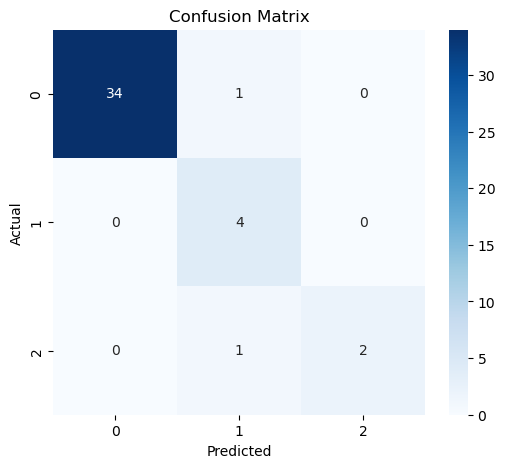

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', probability=True))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Cross-validation

In [9]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in skf.split(X_selected, y):
    pipeline.fit(X_selected.iloc[train_idx], y.iloc[train_idx])
    y_val_pred = pipeline.predict(X_selected.iloc[val_idx])
    scores.append(accuracy_score(y.iloc[val_idx], y_val_pred))

print("\n=== SVM Linear Kernel ===")
for i, accuracy_fold in enumerate(scores):
    print(f"Fold {i+1} Accuracy: {accuracy_fold * 100:.2f}%")

print(f"mean Accuracy: {np.mean(scores) * 100:.2f}%")


=== SVM Linear Kernel ===
Fold 1 Accuracy: 95.24%
Fold 2 Accuracy: 90.48%
Fold 3 Accuracy: 100.00%
Fold 4 Accuracy: 100.00%
Fold 5 Accuracy: 100.00%
Fold 6 Accuracy: 100.00%
Fold 7 Accuracy: 100.00%
Fold 8 Accuracy: 100.00%
Fold 9 Accuracy: 100.00%
Fold 10 Accuracy: 95.24%
mean Accuracy: 98.10%


## Simpan Model

In [10]:
import joblib

model_path = 'model_deteksi_tumbuh gaharu.pkl'

joblib.dump(pipeline, model_path)
joblib.dump(selected_features, 'selected_features.pkl')
print(f"Model disimpan di: {model_path}")
print(f"Fitur yang digunakan disimpan di: selected_features.pkl")

Model disimpan di: model_deteksi_tumbuh gaharu.pkl
Fitur yang digunakan disimpan di: selected_features.pkl


## Prediksi Data Baru

In [11]:
import joblib
model_path = 'model_deteksi_tumbuh gaharu.pkl'

# Load the model
model = joblib.load(model_path)

# Pastikan urutan kolom sesuai
data_baru = pd.DataFrame({
    'Gender': [1],
    'Usia (bulan)': [10],
    'TB (cm)': [75.0],
    'BB (kg)': [5],
    'BB/U': [1],
    'Z-Score BB/U': [-2.75],
    'BB/TB': [1],
    'Z-Score BB/TB': [-2.25],
    'TB/U': [2],
    'Z-Score TB/U': [0.45],
    'Perkembangan Anak': [1],
    'Lingkungan': [0],
    'Imunisasi Dasar': [1],
    'pendapatan keluarga': [0],
    'Pola Makan': [1]
}, columns=X_selected.columns)  # Pastikan urutan kolom sesuai

# Prediksi
pred = model.predict(data_baru)
proba = model.predict_proba(data_baru)

print("\nPredicted Class:", pred[0])
print("Probabilitas Prediksi per Kelas:")
for label, p in zip(model.classes_, proba[0]):
    kelas = 'Tidak Berisiko' if label == 0 else 'Hampir Berisiko' if label == 1 else 'Berisiko'
    print(f" - {label} ({kelas}): {p:.4f}")


Predicted Class: 1
Probabilitas Prediksi per Kelas:
 - 0 (Tidak Berisiko): 0.0523
 - 1 (Hampir Berisiko): 0.7801
 - 2 (Berisiko): 0.1676
